#### Kaggle tmdb-box-office-prediction competition

https://www.kaggle.com/c/tmdb-box-office-prediction

#### Import and View Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt      # matplotlib.pyplot plots data
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv/train.csv')
df_temp = df
df.head(5)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


#### Check for NULL values

In [3]:
df.isna().any()

id                       False
belongs_to_collection     True
budget                   False
genres                    True
homepage                  True
imdb_id                  False
original_language        False
original_title           False
overview                  True
popularity               False
poster_path               True
production_companies      True
production_countries      True
release_date             False
runtime                   True
spoken_languages          True
status                   False
tagline                   True
title                    False
Keywords                  True
cast                      True
crew                      True
revenue                  False
dtype: bool

Text(0.5,1,'Missing Value count By Features')

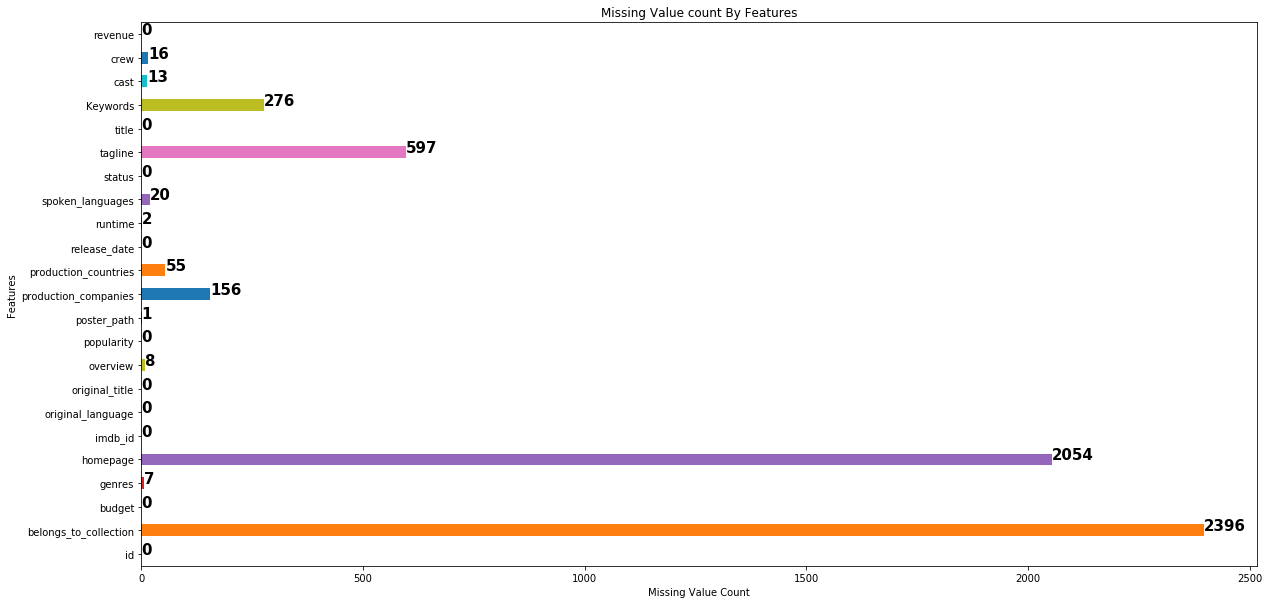

In [4]:
df.isna().sum().plot(kind="barh", figsize=(20,10))
for i, v in enumerate(df.isna().sum()):
    plt.text(v, i, str(v), fontweight='bold', fontsize = 15)
plt.xlabel("Missing Value Count")
plt.ylabel("Features")
plt.title("Missing Value count By Features")

#### Drop unique columns

In [5]:
df = df.drop(['imdb_id'], axis=1)

#### Drop column where 70% data is null 

In [6]:
df = df.drop(['belongs_to_collection', 'homepage'],axis = 1)

In [7]:
df.head(2)

,id,budget,genres,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


#### Find co related features

In [8]:
def plot_corr(df, size=11):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot

    Displays:
        matrix of correlation between columns.  Blue-cyan-yellow-red-darkred => less to more correlated
                                                0 ------------------>  1
                                                Expect a darkred line running from top left to bottom right
    """

    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

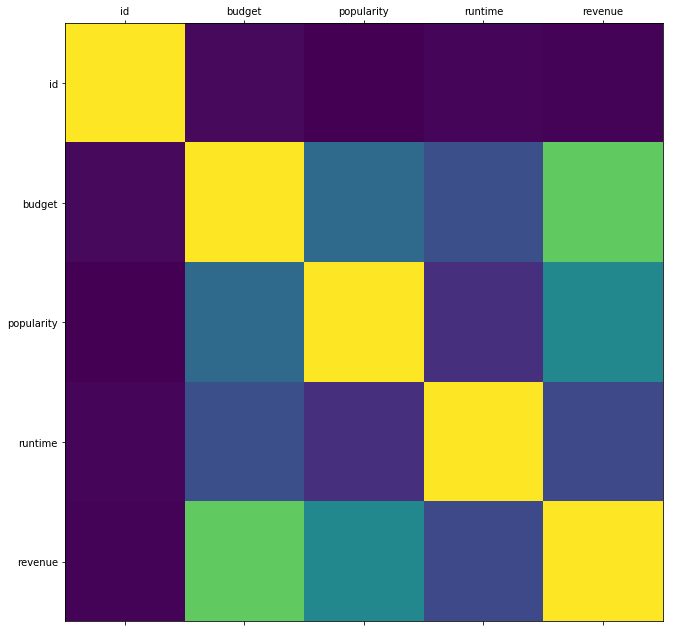

In [9]:
plot_corr(df)

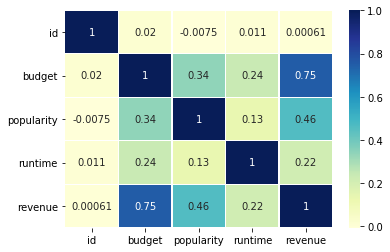

In [10]:
sns.heatmap(df.corr(), cmap='YlGnBu', annot = True, linewidths = 0.2)

#### Lets explore our data more via charts

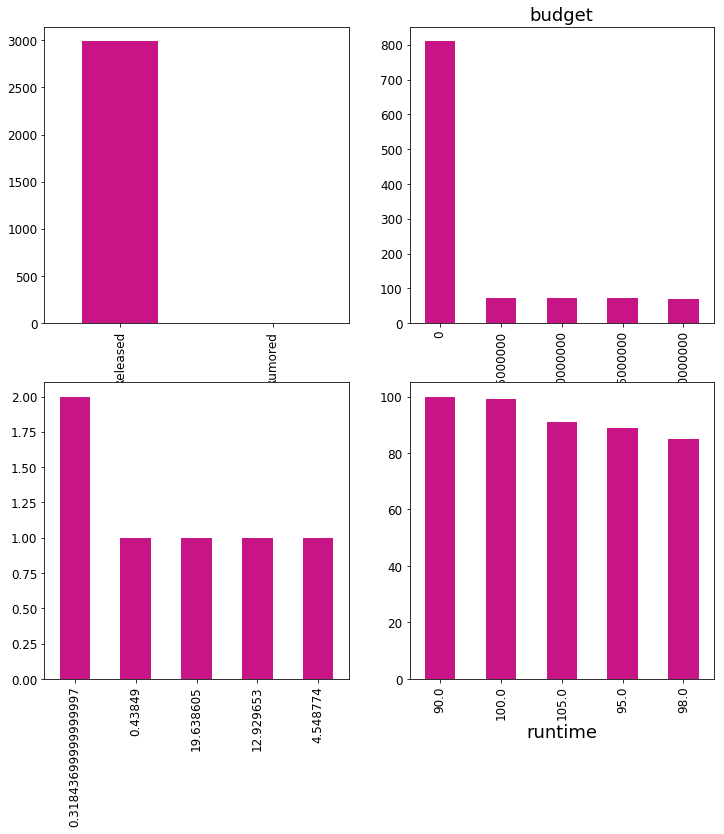

In [11]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 12))

df['status'].value_counts().head(5).plot.bar(ax=axarr[0][0], fontsize=12, color='mediumvioletred')
ax=axarr[0][0].set_xlabel("status", fontsize=18)
df['budget'].value_counts().head(5).plot.bar(ax=axarr[0][1], fontsize=12, color='mediumvioletred')
ax=axarr[0][1].set_title("budget", fontsize=18)
df['popularity'].value_counts().head(5).plot.bar(ax=axarr[1][0], fontsize=12, color='mediumvioletred')
ax=axarr[1][1].set_xlabel("popularity", fontsize=18)
df['runtime'].value_counts().head(5).plot.bar(ax=axarr[1][1], fontsize=12, color='mediumvioletred')
ax=axarr[1][1].set_xlabel("runtime", fontsize=18)


#### Feature Analysis

#### 1. Budget

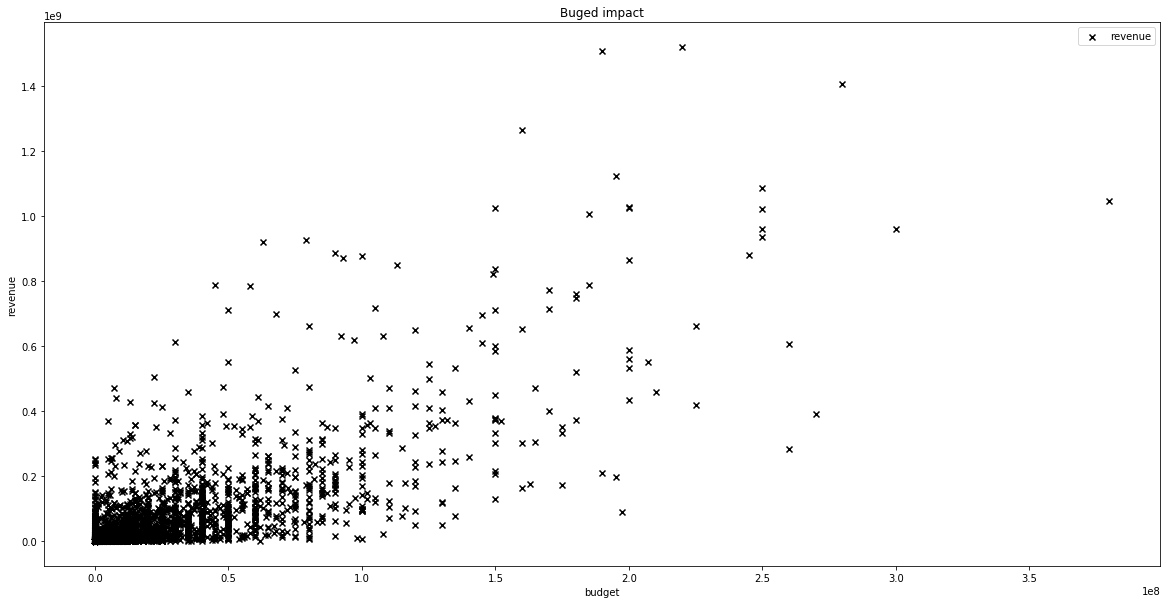

In [12]:
plt.figure(figsize=(20,10))
plt.scatter(x = df['budget'], y = df['revenue'], marker = 'x', color = 'black')

plt.xlabel('budget')
plt.ylabel('revenue')
plt.title('Buged impact')
plt.legend()
plt.show()

#### 2. Popularity

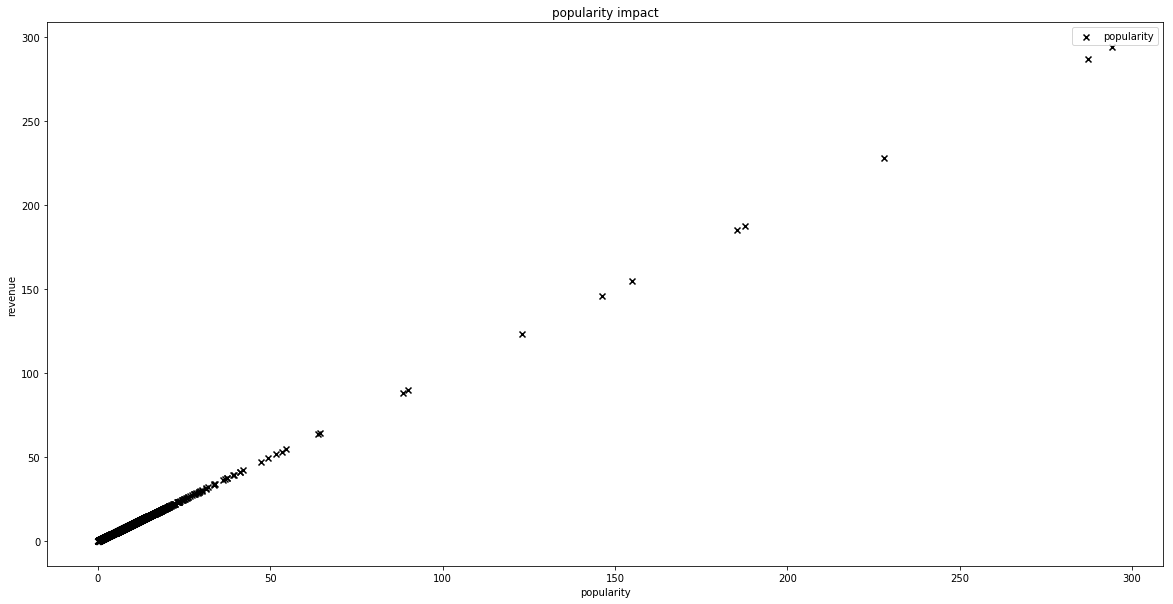

In [13]:
plt.figure(figsize=(20,10))
plt.scatter(x = df['popularity'], y = df['popularity'], marker = 'x', color = 'black')

plt.xlabel('popularity')
plt.ylabel('revenue')
plt.title('popularity impact')
plt.legend()
plt.show()

#### 3. Runtime

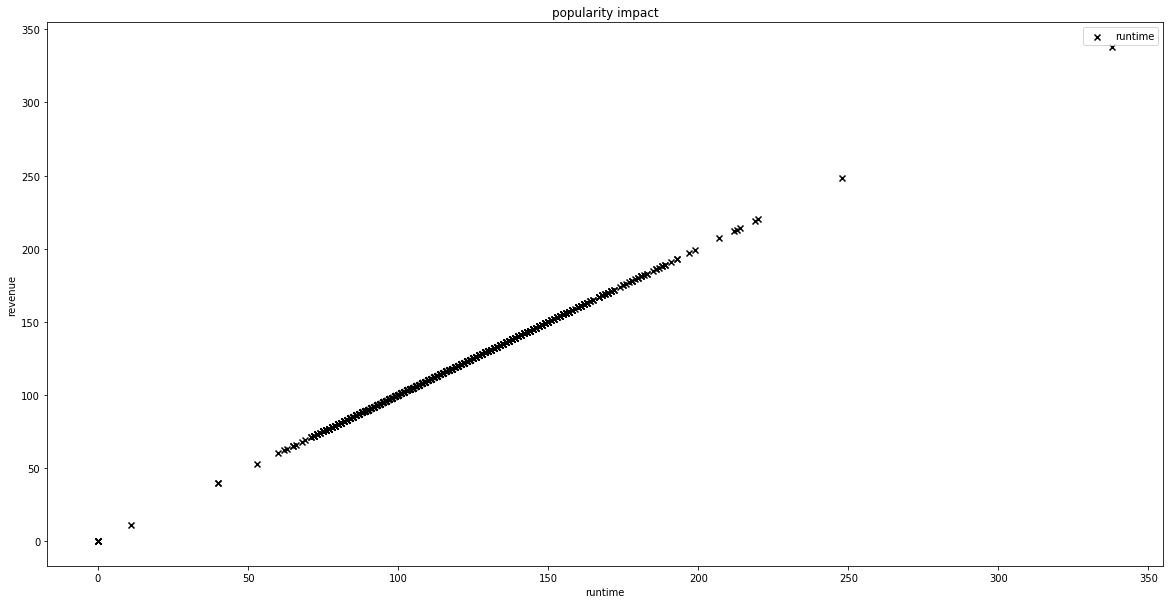

In [14]:
plt.figure(figsize=(20,10))
plt.scatter(x = df['runtime'], y = df['runtime'], marker = 'x', color = 'black')

plt.xlabel('runtime')
plt.ylabel('revenue')
plt.title('popularity impact')
plt.legend()
plt.show()

In [15]:
#X = df.loc[:,df.columns!='revenue']
#y = df['revenue']

df.status = pd.get_dummies(df.status)

df = df[['runtime', 'budget','popularity','status']]
df.isna().any()

runtime        True
budget        False
popularity    False
status        False
dtype: bool

#### Removing Null values from runtime

In [16]:
df['runtime'] = df['runtime'].fillna(method='ffill')
df.isna().any()

runtime       False
budget        False
popularity    False
status        False
dtype: bool

In [17]:
X = df[['runtime', 'budget','popularity','status']]
y = df_temp.revenue

In [18]:
X[:2]

,runtime,budget,popularity,status
0,93.0,14000000,6.575393,1
1,113.0,40000000,8.248895,1


In [19]:
y[:2]

0    12314651
1    95149435
Name: revenue, dtype: int64

#### Split training data into training and test data

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_val,y_train, y_val = train_test_split(X,y,test_size = 0.30, random_state = 42)

In [21]:
print("{0:0.2f}% in training set".format((len(X_train)/len(df.index)) * 100))
print("{0:0.2f}% in test set".format((len(X_val)/len(df.index)) * 100))

70.00% in training set
30.00% in test set


#### Check for 0 or Null values

In [22]:
#'runtime', 'budget','popularity','status'

print("# rows in dataframe {0}".format(len(df)))
print("# rows missing runtime: {0}".format(len(df.loc[df['runtime'].isnull()])))
print("# rows missing budget: {0}".format(len(df.loc[df['budget'].isnull()])))
print("# rows missing popularity: {0}".format(len(df.loc[df['popularity'].isnull()])))
print("# rows missing status: {0}".format(len(df.loc[df['status'].isnull()])))

# rows in dataframe 3000
# rows missing runtime: 0
# rows missing budget: 0
# rows missing popularity: 0
# rows missing status: 0


### Prepare the model

RMSLE method to calculate RMSLE

In [23]:
import numpy as np

def rmsle(y_v,y_p): 
    return np.sqrt(np.mean(np.square(np.log1p(y_v)-np.log1p(y_p)))) 

#### 1. Linear Model

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_val)
print("RMSLE(used in Kaggle competition) score of Linear Model is {}".format(rmsle(y_val,y_pred)))
print("Accuracy: {0:.4f}".format(lr_model.score(X_val,y_val)))
print("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))

RMSLE(used in Kaggle competition) score of Linear Model is 1.9651850618695197
Accuracy: 0.5742
MAE: 45025546.3350


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


#### Training Data Output

In [25]:
test = pd.read_csv('test.csv/test.csv')
test['runtime'] = test['runtime'].fillna(method='ffill')
test["status"] = pd.get_dummies(test.status)
test = test[['runtime', 'budget','popularity','status']]

y_LR_prediction = lr_model.predict(test)

sub_lr = pd.read_csv('sample_submission.csv')
sub_lr['revenue'] = y_LR_prediction
sub_lr.to_csv('LR_Submission.csv', index=False)

#### 2. RandomForestRegressor

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
print("RMSLE score of Random Forest Model is {}".format(rmsle(y_val,y_pred)))
print("Accuracy: {0:.4f}".format(rf_model.score(X_val,y_val)))
print("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))

RMSLE score of Random Forest Model is 2.4958102383210803
Accuracy: 0.5935
MAE: 43743863.4529


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


##### Training Data Output

In [27]:
y_RF_prediction = rf_model.predict(test)

sub_lr['revenue'] = y_RF_prediction
sub_lr.to_csv('RF_Submission.csv', index=False)

#### 3. KNeighborsRegressor

The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

In [28]:
from sklearn.neighbors import KNeighborsRegressor

kn_model = KNeighborsRegressor()
kn_model.fit(X_train, y_train)

y_pred = kn_model.predict(X_val)
print("RMSLE score of KNeighborsRegressor Model is {}".format(rmsle(y_val,y_pred)))
print("Accuracy: {0:.4f}".format(kn_model.score(X_val,y_val)))
print("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))

RMSLE score of KNeighborsRegressor Model is 2.51200337101609
Accuracy: 0.4463
MAE: 48678666.4071


##### Training Data Output

In [29]:
y_kn_prediction = kn_model.predict(test)

sub_lr['revenue'] = y_kn_prediction
sub_lr.to_csv('KN_Submission.csv', index=False)

#### 4. XGBRegressor

In [30]:
from xgboost import XGBRegressor

xg_regressor_model = XGBRegressor()
xg_regressor_model.fit(X_train, y_train)

y_pred = xg_regressor_model.predict(X_val)
print("RMSLE score of XGBRegressor Model is {}".format(rmsle(y_val,y_pred)))
print("Accuracy: {0:.4f}".format(xg_regressor_model.score(X_val,y_val)))
print("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))

RMSLE score of XGBRegressor Model is 2.604091050138997
Accuracy: 0.6598
MAE: 39815165.0339


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


##### Training Data Output

In [31]:
y_xg_regressor_prediction = xg_regressor_model.predict(test)

sub_lr['revenue'] = y_xg_regressor_prediction
sub_lr.to_csv('XGBoost_Regressor_Submission.csv', index=False)

#### 5. XGBClassifier

In [32]:
"""from xgboost import XGBClassifier

xg_classifier_model = XGBClassifier()
xg_classifier_model.fit(X_train, y_train)

y_pred = xg_classifier_model.predict(X_val)
print("RMSLE score of XGBClassifier Model is {}".format(rmsle(y_val,y_pred)))
print("Accuracy: {0:.4f}".format(xg_classifier_model.score(X_val,y_val)))
print("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))"""

'from xgboost import XGBClassifier\n\nxg_classifier_model = XGBClassifier()\nxg_classifier_model.fit(X_train, y_train)\n\ny_pred = xg_classifier_model.predict(X_val)\nprint("RMSLE score of XGBClassifier Model is {}".format(rmsle(y_val,y_pred)))\nprint("Accuracy: {0:.4f}".format(xg_classifier_model.score(X_val,y_val)))\nprint("MAE: {0:.4f}".format(mean_absolute_error(y_pred, y_val)))'

In [33]:
"""y_xg_classifier_prediction = xg_classifier_model.predict(test)

sub_lr['revenue'] = y_xg_classifier_prediction
sub_lr.to_csv('XGBoost_Regressor_Submission.csv', index=False)"""

"y_xg_classifier_prediction = xg_classifier_model.predict(test)\n\nsub_lr['revenue'] = y_xg_classifier_prediction\nsub_lr.to_csv('XGBoost_Regressor_Submission.csv', index=False)"

#### "End Of Project" Check the directory, all the o/p files will be present there. We can upload the best one in the competition